In [1]:
%run init_notebook.py

In [3]:
import numpy as np
import pymc as pm
rng = np.random.default_rng(101)

import seaborn as sns
import arviz as az

In [4]:
import scipy
from src.utils import get_samp

ModuleNotFoundError: No module named 'src'

In [ ]:
arr = np.ones(100)
for i in range(1, arr.shape[0]):
    arr[i] = .98 * arr[i-1] + scipy.stats.norm(0, 1).rvs()
    
y

In [ ]:
plt.plot(y)

In [ ]:
X_star = np.linspace(0, 2, 100)[:, None]

In [ ]:
plt.plot(X_star, y, linewidth=0, marker='o')

In [ ]:
X = X_star.copy()

In [ ]:
X.shape

In [ ]:
y.shape

In [54]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=5)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    sigma = pm.HalfNormal("sigma", sigma=2.0)
    nu = 1 + pm.Gamma(
        "nu", alpha=2, beta=0.1
    )  # add one because student t is undefined for degrees of freedom less than one
    obs = pm.Deterministic('obs', nu)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=y)

    # idata = pm.sample(1000, tune=1000, chains=2, cores=2, nuts_sampler="numpyro")
    idata_prior = pm.sample_prior_predictive()
    idata = pm.sample()

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell, eta, f_rotated_, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 948 seconds.


In [76]:
with model: 
    idata_post = pm.sample_posterior_predictive(idata)

Sampling: [y]


In [71]:
def prior_pred_plot(arr: np.array, **kwargs):
    fig = plt.plot(arr.T, color='grey', alpha=.1, **kwargs)
    return f

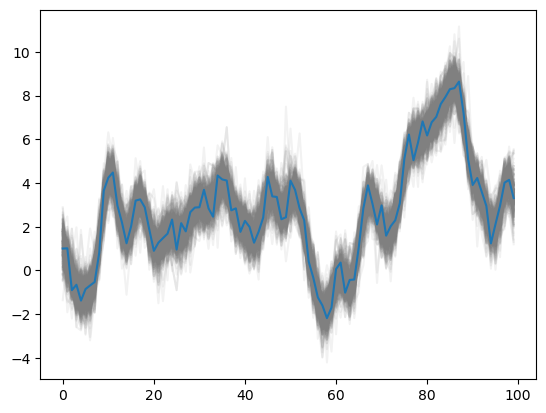

In [81]:
prior_pred_plot(idata_post.posterior_predictive['y'][:, get_samp(1000), :].values.reshape(400, y.shape[0]))
plt.plot(y)

''

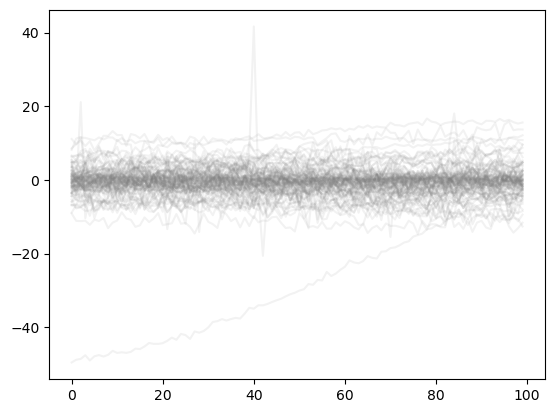

In [74]:
prior_pred_plot(idata.posterior.prior_predictive['y'][0, get_samp(500), :])
;

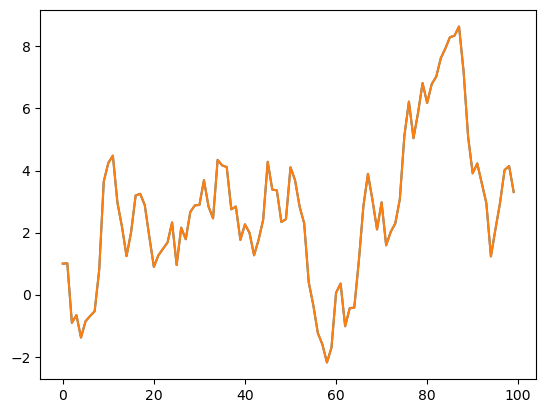

In [58]:
plt.plot(idata_prior.observed_data['y'])

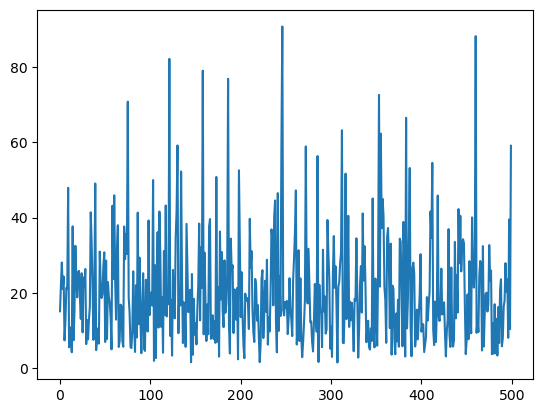

In [53]:
plt.plot(idata_prior.prior['obs'][0]);

In [3]:
lengthscale = 0.1
eta = 2.0
alpha = .3

In [4]:
# cov = eta**2 * pm.gp.cov.RatQuad(1, alpha, lengthscale)
cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)
cov += pm.gp.cov.WhiteNoise(1e-6)

In [5]:
X = np.linspace(1, 10, 200)[:, None]
K = cov(X).eval()

<Axes: >

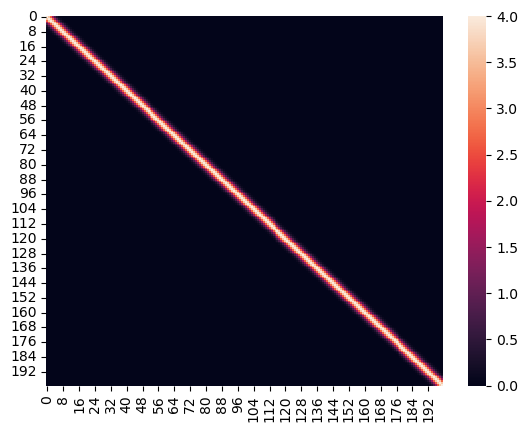

In [6]:
sns.heatmap(K)

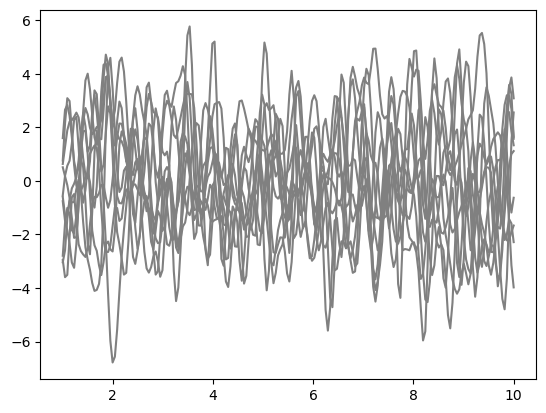

In [7]:
plt.plot(
    X,
    pm.draw(pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=len(K)), draws=10, random_seed=rng).T,
    # alpha=.1,
    color='grey',
);

In [ ]:
class WhiteNoise(pm.gp.cov.Covariance):
    def __init__(self, sigma):
        super(WhiteNoise, self).__init__(1, None)
        self.sigma = sigma

    def diag(self, X):
        return tt.alloc(tt.square(self.sigma), X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return tt.diag(self.diag(X))
        else:
            return tt.alloc(0.0, X.shape[0], Xs.shape[0])

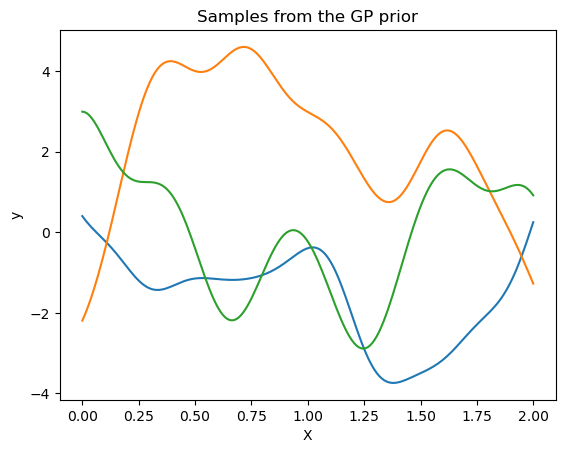

In [77]:
lengthscale = 0.2
eta = 2.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.plot(
    X,
    pm.draw(
        pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=K.shape[0]), draws=3, random_seed=rng
    ).T,
)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [3]:
# cov function

In [59]:
T = 3

In [60]:
from itertools import permutations, combinations

In [80]:
arr = np.concatenate(
    [
        (np.ones((T,T)) * np.array(range(T))[None])[None],
        (np.ones((T,T)) * np.array(range(T))[:, None])[None]
    ],
    axis=0
)

In [87]:
arr.shape

(2, 3, 3)

In [ ]:
arr[:, 0, 2]

In [52]:
[*permutations([[*range(T)], [*range(T)]])]

[([0, 1, 2], [0, 1, 2]), ([0, 1, 2], [0, 1, 2])]

In [46]:
[*zip(range(T), range(T))]

[(0, 0), (1, 1), (2, 2)]

In [43]:
perms = [*combinations(zip(range(T), range(T)), 2)]

In [44]:
perms

[((0, 0), (1, 1)), ((0, 0), (2, 2)), ((1, 1), (2, 2))]

In [ ]:
## quadratic
def cov_quad(T):
    perms = [*permutations(zip(range(T), range(T)))]
    for i in range(T.shape[0]):
        